# Flight Price Buy/Wait ML

**Goal:**  
Use historical flight price snapshots to predict whether a user should **Buy now** or **Wait** for a better price in the next 7 days.

**Stack:** Python · pandas · NumPy · scikit-learn · matplotlib · (optional) seaborn/plotly

Steps:
1. Load & clean data  
2. Feature engineering  
3. Create Buy/Wait label  
4. Time-based train/validation split  
5. Baseline rule  
6. Logistic Regression model  
7. Random Forest model  
8. Compare performance  
9. Simple `buy_or_wait()` helper


# 1.Imports & Config

In [38]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
# Optional: prettier plots
# import seaborn as sns

plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", 50)


# 2.Load Data
Adjust file path + column names to actual CSV.

In [39]:
# Path to your merged Travelpayouts dataset
DATA_PATH = "data/fares_fact.csv"

df_raw = pd.read_csv(DATA_PATH)

print(df_raw.head())
print(df_raw.dtypes)
print("Rows:", len(df_raw))


                    source_name origin destination search_date depart_date  \
0  flight_prices_2025-06-07.csv    NYC         LHR    6/7/2025    8/1/2025   
1  flight_prices_2025-06-07.csv    NYC         LHR    6/7/2025   8/25/2025   
2  flight_prices_2025-06-07.csv    NYC         LHR    6/7/2025    8/4/2025   
3  flight_prices_2025-06-07.csv    NYC         LHR    6/7/2025   7/28/2025   
4  flight_prices_2025-06-07.csv    NYC         LHR    6/7/2025   7/21/2025   

   price snapshot_date    route  lead_time_days  
0    140      6/7/2025  NYC-LHR              55  
1    169      6/7/2025  NYC-LHR              79  
2    172      6/7/2025  NYC-LHR              58  
3    180      6/7/2025  NYC-LHR              51  
4    184      6/7/2025  NYC-LHR              44  
source_name       object
origin            object
destination       object
search_date       object
depart_date       object
price              int64
snapshot_date     object
route             object
lead_time_days     int64
dtype:

#### Rename if needed

In [40]:
df = df_raw.rename(columns={
    "route": "route_id",
    "check_date": "snapshot_date",
    "departure_date": "depart_date",
    # etc…
})

# Ensure dates are datetime
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"])
df["depart_date"] = pd.to_datetime(df["depart_date"])

# Sort for group-wise operations
df = df.sort_values(["route_id", "depart_date", "snapshot_date"]).reset_index(drop=True)

df.head()


,source_name,origin,destination,search_date,depart_date,price,snapshot_date,route_id,lead_time_days
0,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-13,210,2025-06-07,CDG-DXB,6
1,flight_prices_2025-06-08.csv,CDG,DXB,6/8/2025,2025-06-13,210,2025-06-08,CDG-DXB,5
2,flight_prices_2025-06-13.csv,CDG,DXB,6/13/2025,2025-06-15,173,2025-06-13,CDG-DXB,2
3,flight_prices_2025-06-14.csv,CDG,DXB,6/14/2025,2025-06-16,177,2025-06-14,CDG-DXB,2
4,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-17,215,2025-06-07,CDG-DXB,10


# 3.Basic Cleaning

In [41]:
# Drop rows with missing core fields
core_cols = ["route_id", "snapshot_date", "depart_date", "price"]
df = df.dropna(subset=core_cols)

# Remove obviously bad prices (<= 0)
df = df[df["price"] > 0]

print("After cleaning:", df.shape)
df.head()


After cleaning: (133775, 9)


,source_name,origin,destination,search_date,depart_date,price,snapshot_date,route_id,lead_time_days
0,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-13,210,2025-06-07,CDG-DXB,6
1,flight_prices_2025-06-08.csv,CDG,DXB,6/8/2025,2025-06-13,210,2025-06-08,CDG-DXB,5
2,flight_prices_2025-06-13.csv,CDG,DXB,6/13/2025,2025-06-15,173,2025-06-13,CDG-DXB,2
3,flight_prices_2025-06-14.csv,CDG,DXB,6/14/2025,2025-06-16,177,2025-06-14,CDG-DXB,2
4,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-17,215,2025-06-07,CDG-DXB,10


# 4.Feature Engineering

We’ll create features per (route_id, depart_date, snapshot_date):

days_to_departure

day_of_week / month

7-day rolling mean/stdev within route_id+depart_date

pct_change_7d (current vs rolling mean)

In [52]:
# Days between snapshot and departure
df["days_to_departure"] = (df["depart_date"] - df["snapshot_date"]).dt.days

# Calendar features
df["dow"] = df["snapshot_date"].dt.weekday  # 0=Mon
df["month"] = df["snapshot_date"].dt.month
df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)

# Rolling features within each route+departure group
group_cols = ["route_id", "depart_date"]
df = df.sort_values(group_cols + ["snapshot_date"])

df["rolling_mean_7d"] = (
    df.groupby(group_cols)["price"]
      .transform(lambda s: s.rolling(window=7, min_periods=3).mean())
)

df["rolling_std_7d"] = (
    df.groupby(group_cols)["price"]
      .transform(lambda s: s.rolling(window=7, min_periods=3).std())
)

# Price vs 7-day rolling mean (% difference)
df["pct_change_7d"] = (df["price"] - df["rolling_mean_7d"]) / df["rolling_mean_7d"]

df.head()


,source_name,origin,destination,search_date,depart_date,price,snapshot_date,route_id,lead_time_days,days_to_departure,dow,month,is_weekend,rolling_mean_7d,rolling_std_7d,pct_change_7d
0,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-13,210,2025-06-07,CDG-DXB,6,6,5,6,1,NaN,NaN,NaN
1,flight_prices_2025-06-08.csv,CDG,DXB,6/8/2025,2025-06-13,210,2025-06-08,CDG-DXB,5,5,6,6,1,NaN,NaN,NaN
2,flight_prices_2025-06-13.csv,CDG,DXB,6/13/2025,2025-06-15,173,2025-06-13,CDG-DXB,2,2,4,6,0,NaN,NaN,NaN
3,flight_prices_2025-06-14.csv,CDG,DXB,6/14/2025,2025-06-16,177,2025-06-14,CDG-DXB,2,2,5,6,1,NaN,NaN,NaN
4,flight_prices_2025-06-07.csv,CDG,DXB,6/7/2025,2025-06-17,215,2025-06-07,CDG-DXB,10,10,5,6,1,NaN,NaN,NaN


# 5.Create Buy/Wait Label

Label definition (you can tune):

Horizon: next 7 days of snapshot time

Threshold: if the minimum future price in the next 7 days is ≤ current_price × (1 − 5%), we say you should Wait (label=1).

Otherwise, Buy (label=0).

In [43]:
DROP_PCT_THRESHOLD = 0.05  # 5% cheaper within 7 days?
HORIZON_DAYS = 7

def compute_buy_wait_labels(group):
    """
    group: rows for a single route_id + depart_date, sorted by snapshot_date.
    """
    prices = group["price"].values
    dates = group["snapshot_date"].values
    n = len(group)
    labels = np.zeros(n, dtype=int)

    for i in range(n):
        current_price = prices[i]
        current_date = dates[i]

        # Horizon window
        horizon_end = current_date + np.timedelta64(HORIZON_DAYS, "D")

        mask = (dates > current_date) & (dates <= horizon_end)
        if mask.any():
            future_min = prices[mask].min()
            if future_min <= current_price * (1 - DROP_PCT_THRESHOLD):
                labels[i] = 1  # WAIT
            else:
                labels[i] = 0  # BUY
        else:
            # No future info; default BUY (0)
            labels[i] = 0

    group = group.copy()
    group["label_wait"] = labels
    return group


df_labeled = (
    df.groupby(["route_id", "depart_date"], group_keys=False)
      .apply(compute_buy_wait_labels, include_groups=False)
)


df_labeled["label_wait"].value_counts(normalize=True)


label_wait
0    0.892304
1    0.107696
Name: proportion, dtype: float64

# 6.Drop rows with missing engineered features

In [44]:
feature_cols = [
    "price",
    "pct_change_7d",
    "rolling_std_7d",
    "days_to_departure",
    "dow",
    "month",
    "is_weekend"
]

model_df = df_labeled.dropna(subset=feature_cols + ["label_wait"]).copy()
print("Modeling rows:", model_df.shape)
model_df[["label_wait"]].value_counts(normalize=True)


Modeling rows: (113707, 15)


label_wait
0             0.885381
1             0.114619
Name: proportion, dtype: float64

# 7.Time-Based Train/Test Split

Use snapshot_date for time split: first 80% dates for train, last 20% for test.

In [45]:
unique_dates = np.sort(model_df["snapshot_date"].unique())
split_idx = int(len(unique_dates) * 0.8)
train_cutoff = unique_dates[split_idx]

print("Train cutoff date:", train_cutoff)

train_df = model_df[model_df["snapshot_date"] <= train_cutoff].copy()
test_df = model_df[model_df["snapshot_date"] > train_cutoff].copy()

print("Train size:", train_df.shape, "Test size:", test_df.shape)


Train cutoff date: 2025-10-10T00:00:00.000000000
Train size: (91556, 15) Test size: (22151, 15)


# 8. X, y and Scaling

In [46]:
X_train = train_df[feature_cols].values
y_train = train_df["label_wait"].values

X_test = test_df[feature_cols].values
y_test = test_df["label_wait"].values

# Standardize for Logistic Regression (tree model doesn't need scaling, but it's fine)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 9. Baseline Model (Always Buy)

In [47]:
from sklearn.metrics import classification_report

# Baseline: always predict Buy (0)
y_pred_baseline = np.zeros_like(y_test)



print("=== Baseline (Always Buy) ===")
print(
    classification_report(
        y_test,
        y_pred_baseline,
        target_names=["Buy", "Wait"],
        zero_division=0     # avoid noisy warnings when a class has no predicted samples
    )
)



=== Baseline (Always Buy) ===
              precision    recall  f1-score   support

         Buy       0.90      1.00      0.95     19982
        Wait       0.00      0.00      0.00      2169

    accuracy                           0.90     22151
   macro avg       0.45      0.50      0.47     22151
weighted avg       0.81      0.90      0.86     22151



# 10.Logistic Regression

=== Logistic Regression ===
              precision    recall  f1-score   support

         Buy       0.93      0.58      0.71     19982
        Wait       0.13      0.57      0.21      2169

    accuracy                           0.58     22151
   macro avg       0.53      0.58      0.46     22151
weighted avg       0.85      0.58      0.66     22151

ROC AUC: 0.5820950935140843


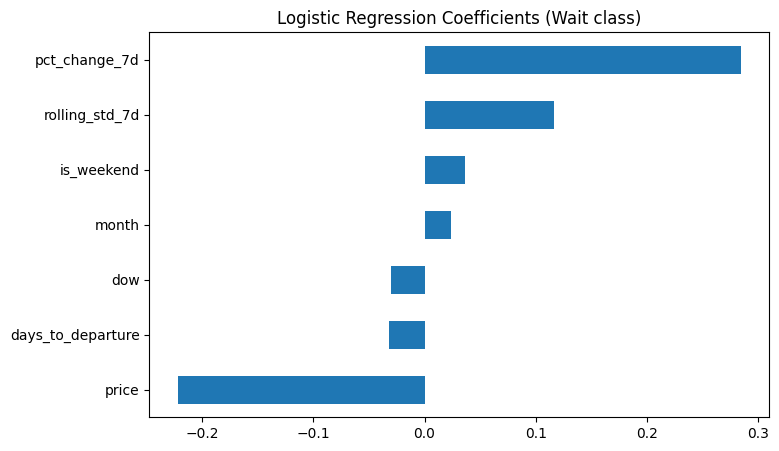

In [48]:
log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    max_iter=500,
    class_weight="balanced",  # helps when Wait is rare
    random_state=42
)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]  # prob of Wait

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=["Buy", "Wait"]))

roc_auc_lr = roc_auc_score(y_test, y_proba_lr)
print("ROC AUC:", roc_auc_lr)


coef = pd.Series(log_reg.coef_[0], index=feature_cols)
coef.sort_values().plot(kind="barh")
plt.title("Logistic Regression Coefficients (Wait class)")
plt.show()


# 11. Random Forest

=== Random Forest ===
              precision    recall  f1-score   support

         Buy       0.92      0.93      0.92     19982
        Wait       0.25      0.21      0.23      2169

    accuracy                           0.86     22151
   macro avg       0.58      0.57      0.58     22151
weighted avg       0.85      0.86      0.86     22151

ROC AUC: 0.6723243865537074


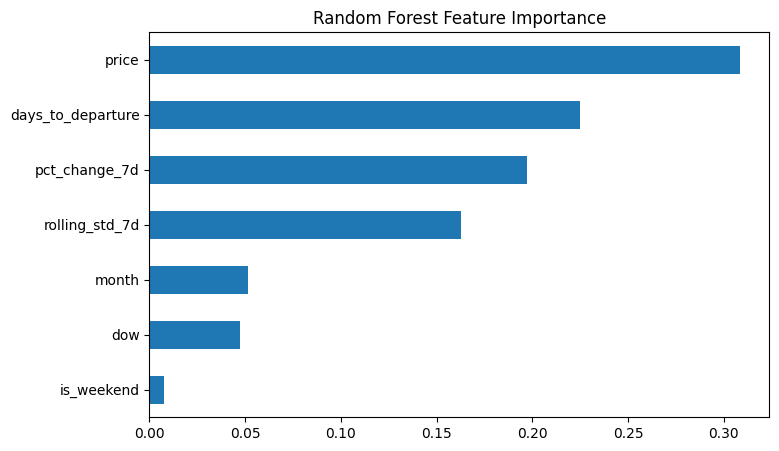

In [49]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=5,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=["Buy", "Wait"]))

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("ROC AUC:", roc_auc_rf)


importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.show()


# 12. ROC Curve Comparison

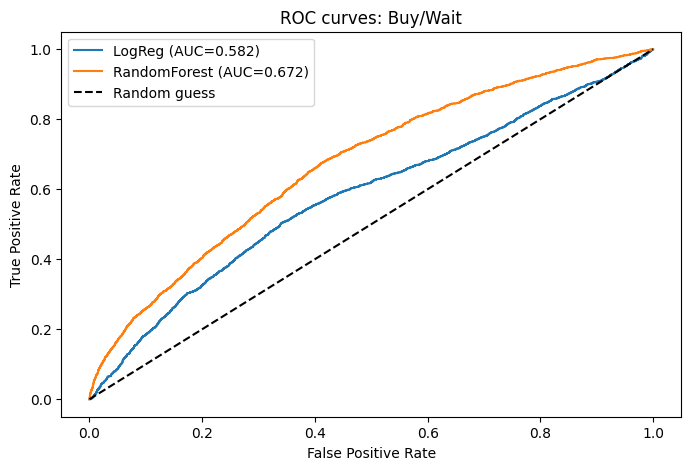

In [50]:
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves: Buy/Wait")
plt.legend()
plt.show()


# 13.Simple buy_or_wait() Helper
In production you’d wrap trained models + scaler. For now, just a simple function using the random forest (or whichever performs best):

In [51]:
def buy_or_wait(
    price,
    pct_change_7d,
    rolling_std_7d,
    days_to_departure,
    dow,
    month,
    is_weekend,
    model=rf
):
    """
    Returns 'Buy' or 'Wait' and the predicted probability of Wait.
    """
    x = np.array([[price, pct_change_7d, rolling_std_7d,
                   days_to_departure, dow, month, is_weekend]])
    
    if isinstance(model, LogisticRegression):
        x_scaled = scaler.transform(x)
        proba_wait = model.predict_proba(x_scaled)[0, 1]
    else:
        # RandomForest or other tree
        proba_wait = model.predict_proba(x)[0, 1]
    
    decision = "Wait" if proba_wait >= 0.5 else "Buy"
    return decision, proba_wait

# Example (dummy numbers)
buy_or_wait(
    price=250,
    pct_change_7d=0.10,
    rolling_std_7d=20,
    days_to_departure=30,
    dow=2,
    month=6,
    is_weekend=0
)


('Buy', np.float64(0.23357056992328717))

# Summary 
- Framed the **Buy/Wait** question as a **binary classification problem** using 7-day future price changes.
- Engineered features for **volatility**, **lead-time**, and **calendar effects**.
- Compared:
  - Baseline (always Buy)
  - Logistic Regression
  - Random Forest
- Evaluated using **classification report** and **ROC AUC**, with a **time-based split** to avoid leakage.
- Exposed a simple `buy_or_wait()` helper for downstream use (e.g., API, dashboard).

This notebook backs up the Data Scientist resume bullet:

> “Trained logistic regression and random forest classifiers on route-level price snapshots to predict Buy vs Wait decisions, using time-based validation and ROC AUC/precision-recall to compare against a seasonal-naive baseline.”
